# Noise2Void - 2D Example

In [1]:
%load_ext autoreload
%autoreload 2
from csbdeep.models import Config, CARE
import numpy as np
from csbdeep.utils import plot_some, plot_history
from csbdeep.utils.n2v_utils import manipulate_val_data

from matplotlib import pyplot as plt

import urllib

import os
import zipfile
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
from skimage.segmentation import find_boundaries

In [3]:
def add_boundary_label(lbl, dtype=np.uint16):
    """ lbl is an integer label image (not binarized) """
    b = find_boundaries(lbl,mode='outer')
    res = (lbl>0).astype(dtype)
    res[b] = 2
    return res


def onehot_encoding(lbl, n_classes=3, dtype=np.uint32):
    """ n_classes will be determined by max lbl value if its value is None """
    from keras.utils import to_categorical
    onehot = np.zeros((*lbl.shape, n_classes), dtype=dtype)
    for i in range(n_classes):
        onehot[lbl == i, ..., i] = 1
    return onehot



In [4]:
def cutHalf(data, repeat):
    data_=data
    print(data_.shape)
    for i in range(repeat):
        newsize=int(data_.shape[1]/2)
        a=data_[:,:newsize,:]
        b=data_[:,newsize:,:]
  #      print(a.shape,b.shape)
        data_=np.concatenate((a,b), axis=0)

        newsize=int(data_.shape[2]/2)
        a=data_[:,:,:newsize]
        b=data_[:,:,newsize:]
        data_=np.concatenate((a,b), axis=0)
        print(data_.shape)
    return data_

In [5]:
# We need to normalize the data before we feed it into our network, and denormalize it afterwards.
def normalize(img, mean, std):
    zero_mean = img - mean
    return zero_mean/std

def denormalize(x, mean, std):
    return x*std + mean

In [6]:
def plot_Y(Y, idx):
    if len(Y.shape) == 4:
        plt.figure(figsize=(25,5))
        for i in range(Y.shape[-1]):
            plt.subplot(1,Y.shape[-1],i+1)
            plt.imshow(Y[idx,...,i])
            print(np.min(Y[idx,...,i]), np.max(Y[idx,...,i]))
    else:
        plt.figure(figsize=(5,5))
        plt.imshow(Y[idx,...])

In [7]:
train_data = np.load('/home/tbuchhol/falcon/StarVoid/train_data/dsb2018_TrainVal20_fixed.npz')
test_data = np.load('/home/tbuchhol/falcon/StarVoid/test_data/dsb2018_Test.npz')

In [8]:
X_train = train_data['X_train'].astype(np.float32)
Y_train = train_data['Y_train'].astype(np.float32)
# X_val = cutHalf(train_data['X_val'][:640, :640], 2).astype(np.float32)
# Y_val = cutHalf(train_data['Y_val'][:640, :640], 2).astype(np.float32)
X_val = train_data['X_val']
Y_val = train_data['Y_val']
X_test = test_data['X_test']
Y_test = test_data['Y_test']
mean, std = np.mean(X_train), np.std(X_train)
X_train = normalize(X_train, mean, std)
# Y = normalize(Y, mean, std)
X_val = normalize(X_val, mean, std)
# Y_val = normalize(Y_val, mean, std)
# X_test = normalize(X_test, mean, std)

In [9]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

(3800, 128, 128) (3800, 128, 128) (670, 128, 128) (670, 128, 128) (50,) (50,)


In [10]:
def convert_to_oneHot(data):
    data_oneHot = np.zeros((*data.shape, 3), dtype=np.float32)
    for i in range(data.shape[0]):
        data_oneHot[i] = onehot_encoding(add_boundary_label(data[i].astype(np.int32)))
#         data_oneHot[i] = add_boundary_label(data[i])[...,np.newaxis]
    return data_oneHot

In [11]:
Y_train_oneHot = convert_to_oneHot(Y_train)
Y_val_oneHot = convert_to_oneHot(Y_val)
# Y_test_oneHot = convert_to_oneHot(Y_test)

0.0 1.0
0.0 1.0
0.0 1.0


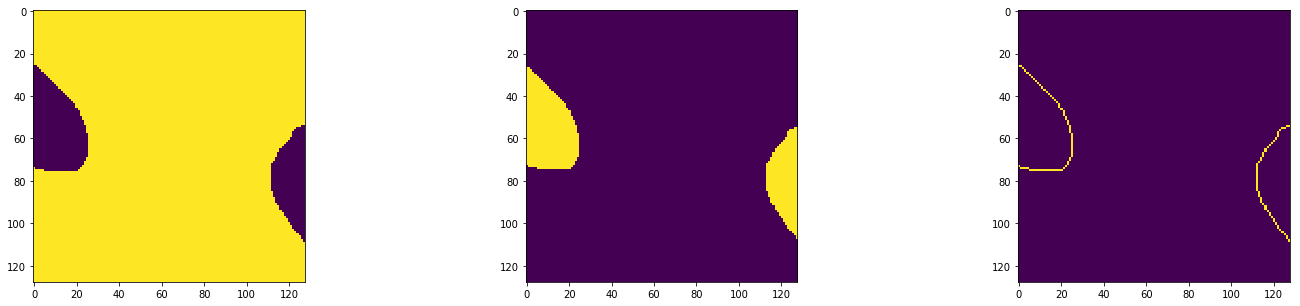

In [12]:
plot_Y(Y_train_oneHot, 0)

In [13]:
Y_train_oneHot.dtype

dtype('float32')

In [14]:
Y_train_oneHot.shape

(3800, 128, 128, 3)

In [15]:
Y_train = np.concatenate((X_train[..., np.newaxis], np.zeros(X_train.shape, dtype=np.float32)[...,np.newaxis], Y_train_oneHot), axis=3)

In [16]:
Y_train.dtype

dtype('float32')

-3.2908144 4.857194
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0


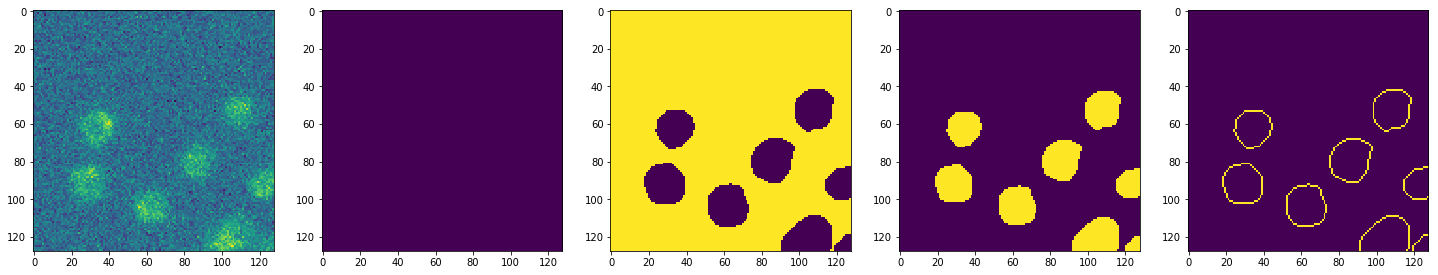

In [17]:
plot_Y(Y_train, 15)

In [18]:
X_validation = X_val[...,np.newaxis]
Y_validation = Y_val[...,np.newaxis]

In [19]:
# 1. Option
Y_validation = np.concatenate((X_validation.copy(), np.zeros(X_validation.shape, dtype=np.float32)), axis=3) 
manipulate_val_data(X_validation, Y_validation, num_pix=128*128/64 , shape=(128, 128))

/home/tbuchhol/GitRepos/StarVoid/noise2seg/csbdeep/utils/n2v_utils.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return patch[slices]


In [20]:
Y_validation.shape

(670, 128, 128, 2)

In [21]:
Y_validation = np.concatenate((Y_validation, Y_val_oneHot), axis=3)

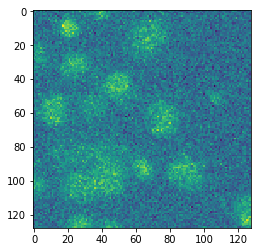

In [22]:
plt.imshow(X_validation[150,...,0])

-2.3647138525493094 3.4112628030864194
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


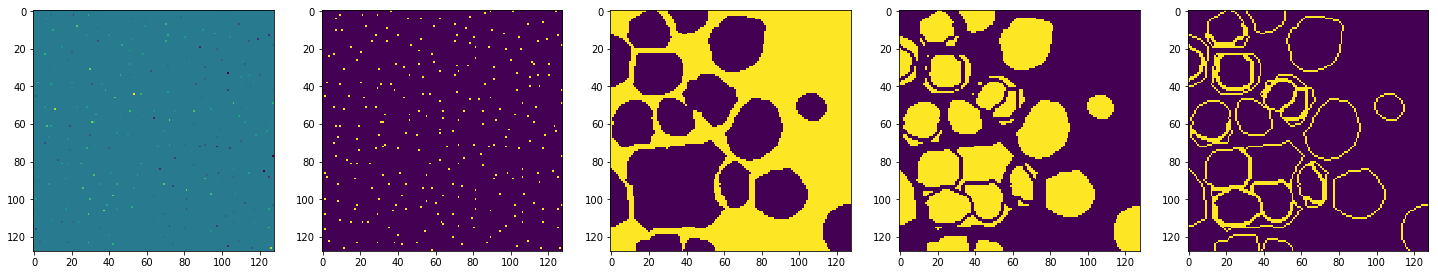

In [23]:
plot_Y(Y_validation, 150)

from csbdeep.internals.train import Noise2VoidDataWrapper 
from csbdeep.utils.n2v_utils import pm_uniform_withCP

dw = Noise2VoidDataWrapper(X_train[..., np.newaxis], Y_train, 2, num_pix=64, shape=(64,64), value_manipulation=pm_uniform_withCP(5))

batch = dw.__getitem__(0)

plt.imshow(batch[0][0,...,0])

plot_Y(batch[1],0)

## Configure

To use Noise2Void with the CARE framework we have to switch the <code>train_scheme</code> from <code>'CARE'</code> to <code>'Noise2Void'</code>. This will turn on the pixel-masking which is needed for Noise2Void training. Furhtermore it is recommended to increase the <code>train_batch_size</code> and enable <code>batch_norm</code>. 

To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels we manipulated <code>n2v_num_pix</code> = 64 pixels simultaniously. 

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

In [24]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = Config('SYXC', n_channel_in=1, n_channel_out=4, unet_kern_size = 3, train_steps_per_epoch=400, train_loss='mse',
                train_epochs=15,
                batch_norm = True, train_scheme = 'Noise2Void', train_batch_size = 128, n2v_num_pix = 64,
                n2v_patch_shape = (64, 64), n2v_manipulator = 'uniform_withCP', n2v_neighborhood_radius='5', 
                use_denoising=1)

vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 15,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0},
 'batch_norm': True,
 'train_scheme': 'Noise2Void',
 'n2v_num_pix': 64,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': '5',
 'use_denoising': 1}

In [25]:
model = CARE(config, 'n2s_testing', basedir='models')

/home/tbuchhol/GitRepos/StarVoid/noise2seg/csbdeep/models/care_standard.py:118: UserWarning: output path for model already exists, files may be overwritten: /home/tbuchhol/GitRepos/StarVoid/noise2seg/examples/2D/models/n2s_testing
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## Training Data Preparation

For training we load __one__ set of low-SNR images and normalize them to 0-mean and 1-std. This data is used as input data and stored in the variable <code>X</code>. Our target <code>Y</code> is <code>X</code> concatenated with a zero-tensor of the same shape. This zero-tensor is used for the masking of the pixels during training. 

### Validation Data Preparation

There are two possiblities to build the validation set:

1. Training-Data like: Meaning that the validations loss is only computed on a fixed number of manipulated (masked) pixels. This means that we randomly select a fixed number of pixels before training and manipulate them like it is done for the training data during training. 
2. Test-Data like: Meaning that the validation loss is computed on all pixels of the validation set.
The pixels are __not__ manipulated.
This setup is more like the setup during testing.

In our paper we chose *option 1* to have the same loss during validation as during training. But using *option 2* will result in a more stable validation loss since it is computed over __all__ instead of a subset of pixels.

## Training

In [26]:
print(X_train[..., np.newaxis].shape, Y_train.shape, X_validation.shape, Y_validation.shape)

(3800, 128, 128, 1) (3800, 128, 128, 5) (670, 128, 128, 1) (670, 128, 128, 5)


In [27]:
def print_stats(img):
    print(np.mean(img), np.std(img))

In [28]:
print_stats(X_train)

2.8465482e-07 0.99999756


In [29]:
print_stats(X_validation)

-0.021759793092866415 0.9850403447428404


-2.6051383 8.786793
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0


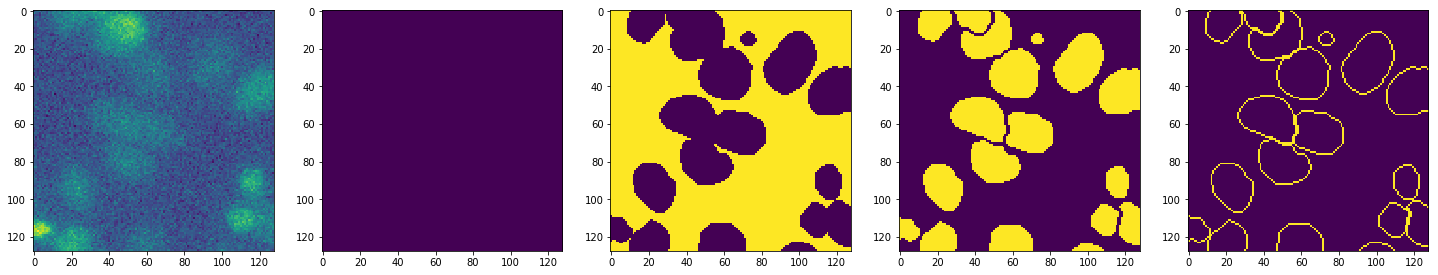

In [30]:
plot_Y(Y_train, 92)

In [31]:
X_ = X_train.copy()
X_train_aug = np.concatenate((X_train, np.rot90(X_, 2, (1, 2))))
X_train_aug = np.concatenate((X_train_aug, np.flip(X_train_aug, axis=1), np.flip(X_train_aug, axis=2)))
Y_ = Y_train.copy()
Y_train_aug = np.concatenate((Y_train, np.rot90(Y_, 2, (1, 2))))
Y_train_aug = np.concatenate((Y_train_aug, np.flip(Y_train_aug, axis=1), np.flip(Y_train_aug, axis=2)))

In [32]:
X_ = X_validation.copy()
X_validation_aug = np.concatenate((X_validation, np.rot90(X_, 2, (1, 2))))
X_validation_aug = np.concatenate((X_validation_aug, np.flip(X_validation_aug, axis=1), np.flip(X_validation_aug, axis=2)))
Y_ = Y_validation.copy()
Y_validation_aug = np.concatenate((Y_validation, np.rot90(Y_, 2, (1, 2))))
Y_validation_aug = np.concatenate((Y_validation_aug, np.flip(Y_validation_aug, axis=1), np.flip(Y_validation_aug, axis=2)))

In [33]:
X_train.shape

(3800, 128, 128)

In [34]:
X_train_aug.shape

(22800, 128, 128)

In [35]:
X_validation.shape

(670, 128, 128, 1)

In [36]:
X_validation_aug.shape

(4020, 128, 128, 1)

In [37]:
Y_validation_aug.shape

(4020, 128, 128, 5)

In [38]:
train_frac = int(np.round((1/100) * X_train_aug.shape[0]))
print(train_frac)

228


In [39]:
Y_train_aug_frac = Y_train_aug.copy()

In [40]:
Y_train_aug_frac[train_frac:,...,1:] *= 0

In [41]:
Y_train_aug_frac.shape

(22800, 128, 128, 5)

In [42]:
X_train_aug.shape

(22800, 128, 128)

In [43]:
X_train_aug.shape

(22800, 128, 128)

In [44]:
Y_train_aug_frac.shape

(22800, 128, 128, 5)

In [45]:
history = model.train(X_train_aug[..., np.newaxis],Y_train_aug_frac, validation_data=(X_validation_aug,Y_validation_aug))

Epoch 1/15
400/400 [==============================] - 179s 448ms/step - loss: 0.6021 - mse: 0.4695 - mae: 0.3789 - val_loss: 1.1084 - val_mse: 0.4982 - val_mae: 0.3991
Epoch 2/15
400/400 [==============================] - 140s 350ms/step - loss: 0.5668 - mse: 0.4530 - mae: 0.3715 - val_loss: 0.9798 - val_mse: 0.4742 - val_mae: 0.3952
Epoch 3/15
400/400 [==============================] - 140s 350ms/step - loss: 0.5647 - mse: 0.4485 - mae: 0.3704 - val_loss: 0.9369 - val_mse: 0.5356 - val_mae: 0.3676
Epoch 4/15
400/400 [==============================] - 144s 361ms/step - loss: 0.5628 - mse: 0.4504 - mae: 0.3699 - val_loss: 0.8853 - val_mse: 0.4088 - val_mae: 0.3513
Epoch 5/15
400/400 [==============================] - 139s 347ms/step - loss: 0.5612 - mse: 0.4496 - mae: 0.3703 - val_loss: 0.8594 - val_mse: 0.4404 - val_mae: 0.3946
Epoch 6/15
400/400 [==============================] - 162s 406ms/step - loss: 0.5619 - mse: 0.4472 - mae: 0.3694 - val_loss: 0.8864 - val_mse: 0.3725 - val_mae:

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


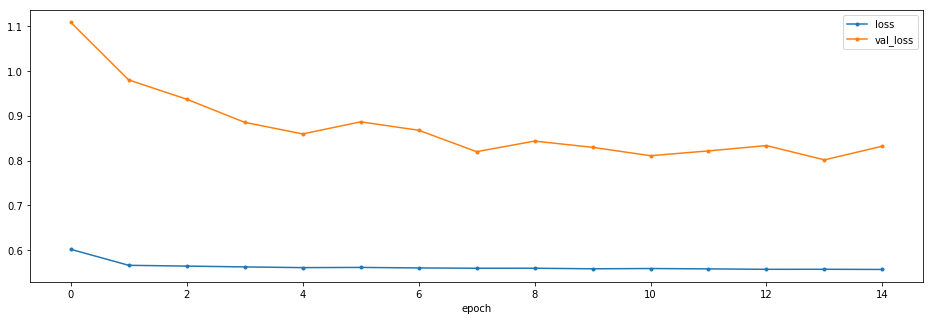

In [46]:
# Lets look at the training and validation loss.

print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


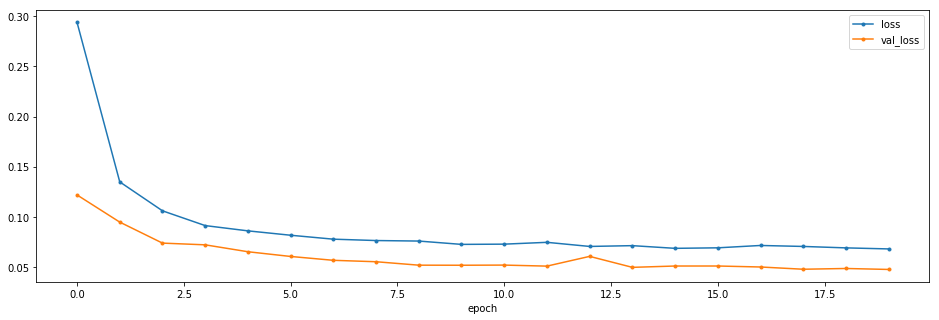

In [40]:
# Lets look at the training and validation loss.

print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [68]:
model.load_weights('weights_best.h5')

In [47]:
test29 = X_test[10]

In [48]:
test29 = (test29 - mean)/std

In [86]:
pred =  model.predict(test29, 'YX', normalizer=None)

In [87]:
np.mean(test29)

0.31083488

In [88]:
pred.shape

(256, 256, 4)

In [89]:
denoised = pred[...,0]

In [103]:
seg_exp = np.exp(pred[...,1:])

segmentation = seg_exp/np.sum(seg_exp, axis=2)[..., np.newaxis]

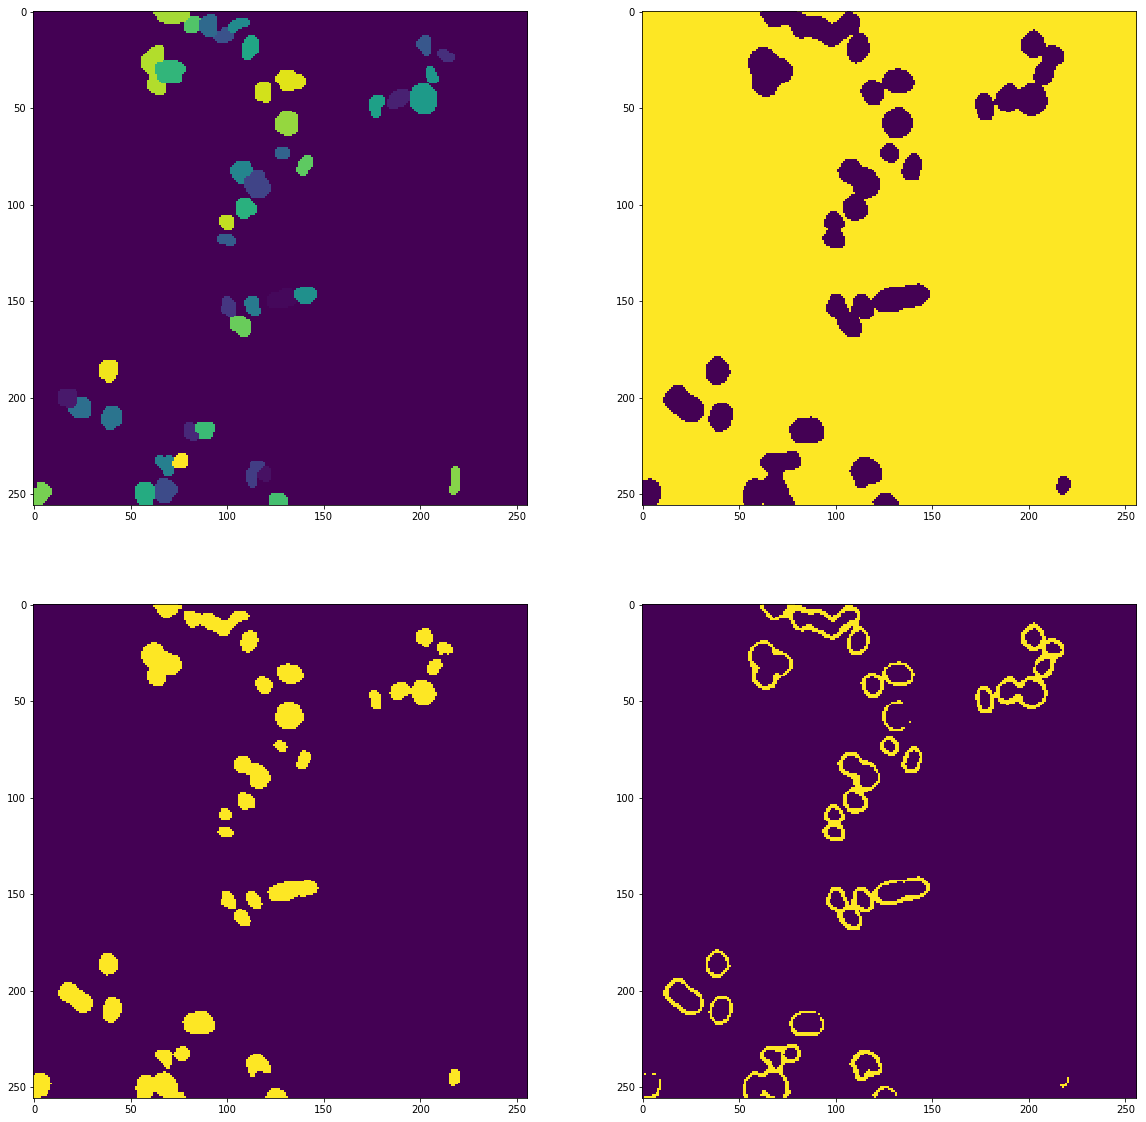

In [152]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(Y_test[10])
# plt.subplot(1,5,2)
# plt.imshow(denoised[...])
plt.subplot(2,2,2)
plt.imshow(segmentation[...,0]>0.5)
plt.subplot(2,2,3)
plt.imshow(segmentation[...,1]>0.2)
plt.subplot(2,2,4)
plt.imshow((segmentation[...,2]>0.5))

In [106]:
labels = np.argmax(segmentation, axis=2)

In [107]:
labels.shape

(256, 256)

In [108]:
response = np.zeros(segmentation.shape, dtype=np.int16)

In [109]:
response[labels == 0, 0] =1
response[labels == 1, 1] =1
response[labels == 2, 2] =1

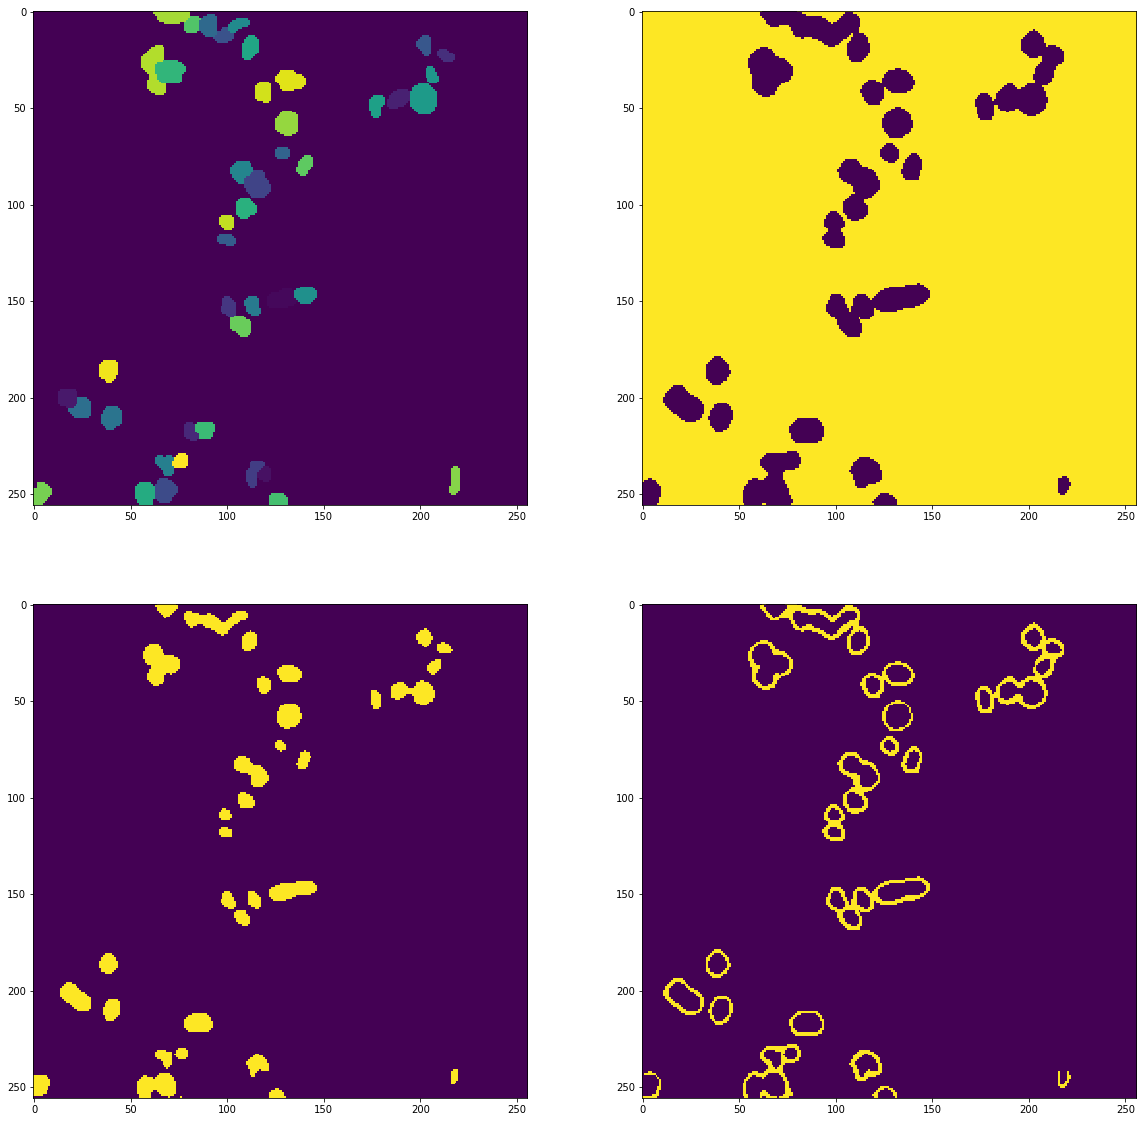

In [110]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(Y_test[10])
# plt.subplot(1,5,2)
# plt.imshow(denoised[...])
plt.subplot(2,2,2)
plt.imshow(response[...,0])
plt.subplot(2,2,3)
plt.imshow(response[...,1])
plt.subplot(2,2,4)
plt.imshow(response[...,2])

In [111]:
from scipy import ndimage
from numba import jit

@jit
def pixel_sharing_bipartite(lab1, lab2):
    assert lab1.shape == lab2.shape
    psg = np.zeros((lab1.max()+1, lab2.max()+1), dtype=np.int)
    for i in range(lab1.size):
        psg[lab1.flat[i], lab2.flat[i]] += 1
    return psg

def intersection_over_union(psg):
    rsum = np.sum(psg, 0, keepdims=True)
    csum = np.sum(psg, 1, keepdims=True)
    return psg / (rsum + csum - psg)

def matching_overlap(psg, fractions=(0.5,0.5)):
    """
    create a matching given pixel_sharing_bipartite of two label images based on mutually overlapping regions of sufficient size.
    NOTE: a true matching is only gauranteed for fractions > 0.5. Otherwise some cells might have deg=2 or more.
    NOTE: doesnt break when the fraction of pixels matching is a ratio only slightly great than 0.5? (but rounds to 0.5 with float64?)
    """
    afrac, bfrac = fractions
    tmp = np.sum(psg, axis=1, keepdims=True)
    m0 = np.where(tmp==0,0,psg / tmp)
    tmp = np.sum(psg, axis=0, keepdims=True)
    m1 = np.where(tmp==0,0,psg / tmp)
    m0 = m0 > afrac
    m1 = m1 > bfrac
    matching = m0 * m1
    matching = matching.astype('bool')
    return matching

def seg(lab_gt, lab, partial_dataset=False):
    """
    calculate seg from pixel_sharing_bipartite
    seg is the average conditional-iou across ground truth cells
    conditional-iou gives zero if not in matching
    ----
    calculate conditional intersection over union (CIoU) from matching & pixel_sharing_bipartite
    for a fraction > 0.5 matching. Any CIoU between matching pairs will be > 1/3. But there may be some
    IoU as low as 1/2 that don't match, and thus have CIoU = 0.
    """
    psg = pixel_sharing_bipartite(lab_gt, lab)
    iou = intersection_over_union(psg)
    matching = matching_overlap(psg, fractions=(0.5, 0))
    matching[0,:] = False
    matching[:,0] = False
    n_gt = len(set(np.unique(lab_gt)) - {0})
    n_matched = iou[matching].sum()
    if partial_dataset:
        return n_matched , n_gt
    else:
        return n_matched / n_gt

In [147]:
labels_th,_ = ndimage.label(segmentation[...,1]>0.2)

In [148]:
labels_resp5,_ = ndimage.label(response[...,1])

In [149]:
gt =Y_test[10]

In [150]:
seg_th = seg(gt, labels_th.astype(np.int16))
seg_resp5 = seg(gt, labels_resp5.astype(np.int16))

In [151]:
print("th", seg_th)
print('r5', seg_resp5)

th 0.5587968517506288
r5 0.5207653274209962


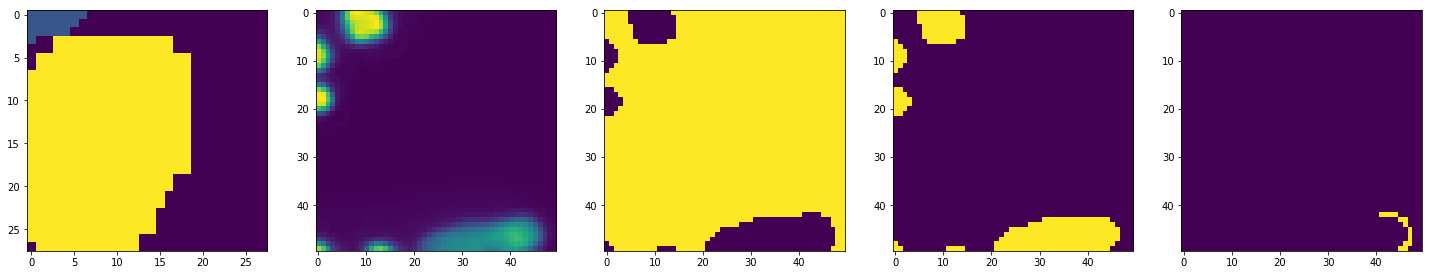

In [125]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(Y_train[10][100:150,100:150])
plt.subplot(1,5,2)
plt.imshow(denoised[100:150,100:150])
plt.subplot(1,5,3)
plt.imshow(response[100:150,100:150,0])
plt.subplot(1,5,4)
plt.imshow(response[100:150,100:150,1])
plt.subplot(1,5,5)
plt.imshow(response[100:150,100:150,2])

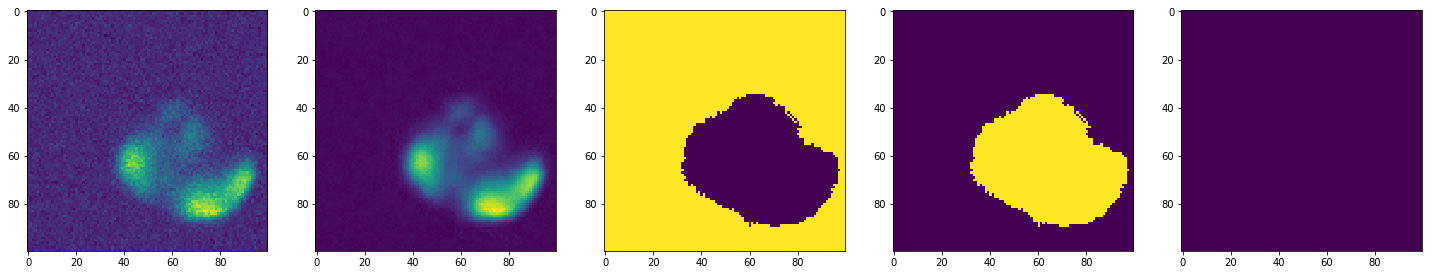

In [138]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(Y_train[0,200:300,250:350,0])
plt.subplot(1,5,2)
plt.imshow(denoised[200:300,250:350])
plt.subplot(1,5,3)
plt.imshow(response[200:300,250:350,0])
plt.subplot(1,5,4)
plt.imshow(response[200:300,250:350,1])
plt.subplot(1,5,5)
plt.imshow(response[200:300,250:350,2])

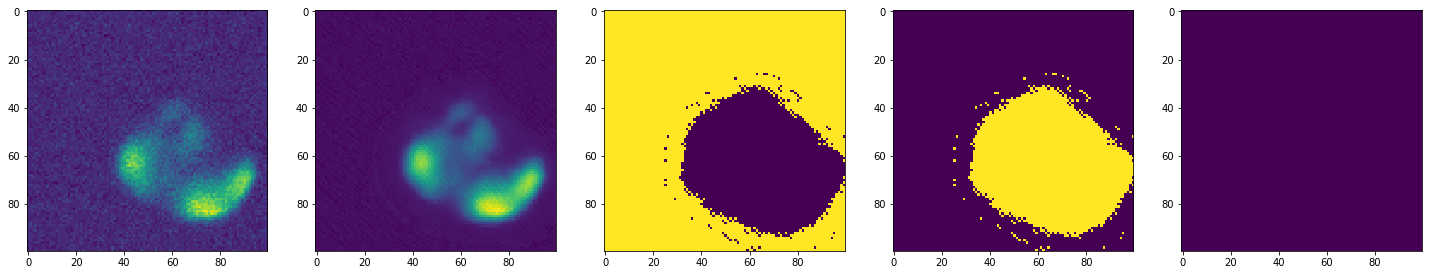

In [60]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(Y_train[0,200:300,250:350,0])
plt.subplot(1,5,2)
plt.imshow(denoised[200:300,250:350])
plt.subplot(1,5,3)
plt.imshow(response[200:300,250:350,0])
plt.subplot(1,5,4)
plt.imshow(response[200:300,250:350,1])
plt.subplot(1,5,5)
plt.imshow(response[200:300,250:350,2])

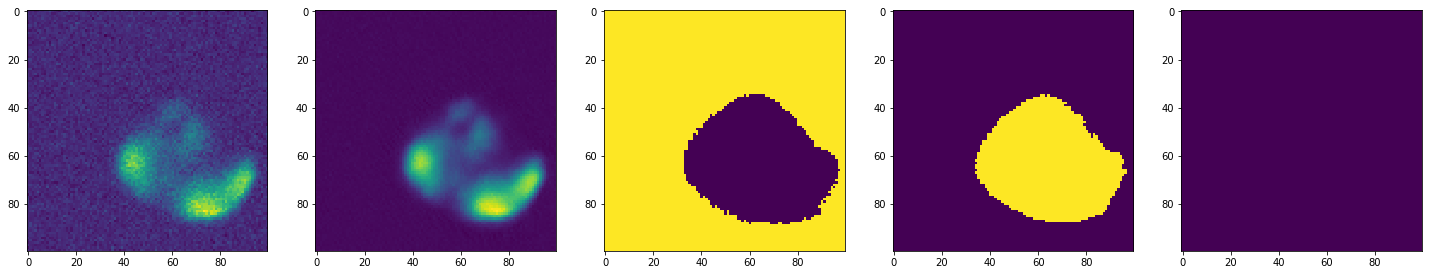

In [70]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(Y_train[0,200:300,250:350,0])
plt.subplot(1,5,2)
plt.imshow(denoised[200:300,250:350])
plt.subplot(1,5,3)
plt.imshow(seg[200:300,250:350,0]>0.5)
plt.subplot(1,5,4)
plt.imshow(seg[200:300,250:350,1]>0.5)
plt.subplot(1,5,5)
plt.imshow(seg[200:300,250:350,2]>0.5)

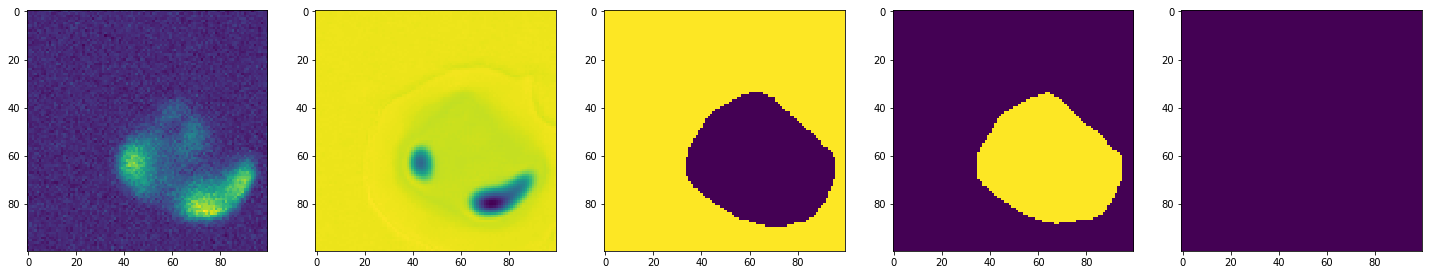

In [53]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(Y_train[0,200:300,250:350,0])
plt.subplot(1,5,2)
plt.imshow(denoised[200:300,250:350])
plt.subplot(1,5,3)
plt.imshow(seg[200:300,250:350,0]>0.5)
plt.subplot(1,5,4)
plt.imshow(seg[200:300,250:350,1]>0.5)
plt.subplot(1,5,5)
plt.imshow(seg[200:300,250:350,2]>0.5)

## Evaluation

For the evaluation we load the test low-SNR and ground truth data. Since we have simulated low- and high-SNR images via exposure, we have to normalize the values to compute a meaningful PSNR value. The ground truth data has a simulated exposure of 10'000 and the low-SNR data has an exposure of 20. 

In [ ]:
# model.load_weights( name='weights_now.h5')

In [ ]:
test_gt = np.load('data/N2V_exampleData/N2V_gt.npy')
# Normalize exposure
test_gt = test_gt/10000 * 20

In [ ]:
test_lowSNR = np.load('data/N2V_exampleData/N2V_lowSNR.npy')
# normalize data with mean and std of the training data
test_lowSNR = normalize(test_lowSNR, mean, std)

In [ ]:
predictions = []
# Denoise all images
for i in range(test_lowSNR.shape[0]):
    predictions.append(denormalize(model.predict(test_lowSNR[i], axes='YXC',normalizer=None ), mean, std))
predictions = np.array(predictions)

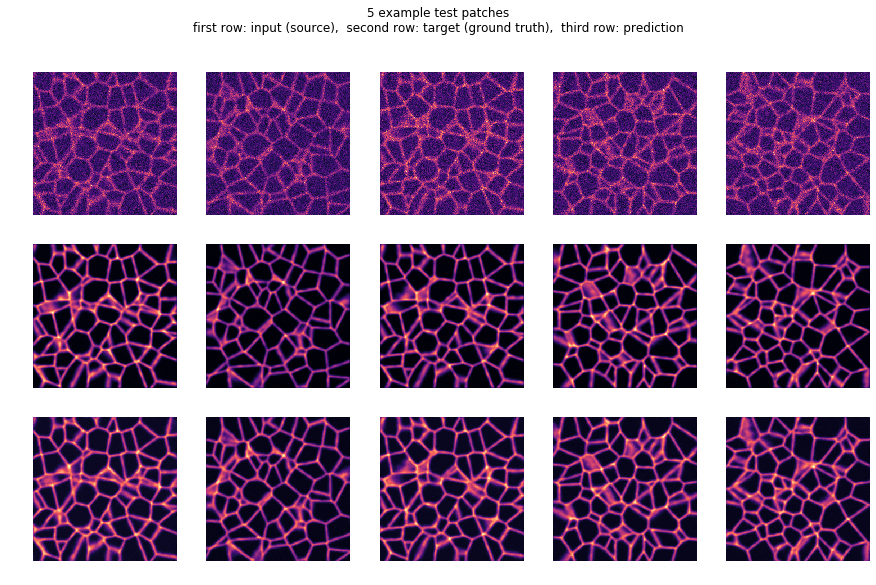

In [13]:
plt.figure(figsize=(15,9))
plot_some(test_lowSNR[:5], test_gt[:5], predictions[:5])
plt.suptitle('5 example test patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: prediction');

In [14]:
def PSNR(gt, pred, range_):
    mse = np.mean((gt - pred)**2)
    return 20 * np.log10((range_)/np.sqrt(mse))

In [15]:
def stack_PSNR(gt, pred):
    psnr = 0
    min_gt, max_gt = np.min(gt), np.max(gt)
    for i in range(gt.shape[0]):
        psnr += PSNR(gt[i], pred[i], max_gt-min_gt)
    
    return psnr/gt.shape[0]

In [16]:
print('PSNR')
print('Input:', stack_PSNR(test_gt, test_lowSNR))
print('Prediction:', stack_PSNR(test_gt, predictions))

PSNR
Input: 8.761603419810816
Prediction: 31.44227559267284


In [149]:
from tifffile import imread


In [150]:
img = imread('/home/tbuchhol/falcon/StarVoid/outdata/sv_CTC_n0_baseline/train_1/mask000.tif')

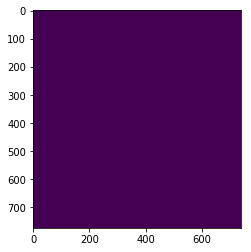

In [155]:
plt.imshow(img[...,2])